In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [26]:
# parse logs
# plot losses and accuracies at end of each epoch

def parse_log(log):
    
    res = []
    with open(log, 'r') as fi:
        for line in fi:
            if 'Epoch' in line:
                epoch = int(line.split()[-4])
                time = float(line.split()[-1][:-1])
            elif 'Train Loss' in line:
                train_loss = float(line.split()[-5])
                train_acc = float(line.split()[-1][:-1])
            elif 'Valid Loss' in line:
                valid_loss = float(line.split()[-5])
                valid_acc = float(line.split()[-1][:-1])
                
                # save
                res.append([epoch, time, train_loss, train_acc, valid_loss, valid_acc])
                
    df = pd.DataFrame(res, columns=['epoch', 'time', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
    df['run'] = str(log).split('/')[-1][:-4]
    
    return df
            
    

In [29]:
def parse_all_logs():
    
    logs = sorted(list(Path('logs').glob('*.log')), key = lambda x: int(str(x).split('_')[1][:-4]))

    df_list = []
    for log in logs:
        df = parse_log(log)

        df_list.append(df)

    df = pd.concat(df_list, ignore_index=True)
    
    return df

In [30]:
df = parse_all_logs()
df.head()

,epoch,time,train_loss,train_acc,valid_loss,valid_acc,run
0,1,4.08,1.526,50.99,1.446,52.70,block_1
1,2,8.17,1.419,53.80,1.427,53.66,block_1
2,3,12.27,1.382,54.78,1.448,53.03,block_1
3,4,16.36,1.356,55.47,1.395,54.28,block_1
4,5,20.45,1.342,55.71,1.386,54.15,block_1


In [94]:
def plot_loss(df, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    df['blocks'] = df['run'].str.split('_', expand=True)[1].astype(int)
    colors = ['C0', 'C1', 'C2']
    
    for i, (grp, data) in enumerate(df.groupby('blocks')):
        ax.plot(data['epoch'], data['train_loss'], label=f'Train - {grp}', color=colors[i], lw=2)
        ax.plot(data['epoch'], data['valid_loss'], label=f'Valid - {grp}', ls='--', color=colors[i], lw=2)
    
    ax.legend(fontsize=11)
    ax.grid(alpha=0.2)
    ax.set_ylabel('Loss', size=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_title('Model Loss', size=14)
    ax.tick_params(labelsize=11)

In [99]:
def plot_acc(df, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    df['blocks'] = df['run'].str.split('_', expand=True)[1].astype(int)
    colors = ['C0', 'C1', 'C2']
    
    for i, (grp, data) in enumerate(df.groupby('blocks')):
        ax.plot(data['epoch'], data['train_acc'], label=f'Train - {grp}', color=colors[i], lw=2)
        ax.plot(data['epoch'], data['valid_acc'], label=f'Valid - {grp}', ls='--', color=colors[i], lw=2)
    
    #ax.legend(fontsize=11)
    ax.grid(alpha=0.2)
    ax.set_ylabel('Accuracy (%)', size=12)
    ax.set_xlabel('Epoch', size=12)
    ax.set_title('Model Accuracy', size=14)
    ax.tick_params(labelsize=11)

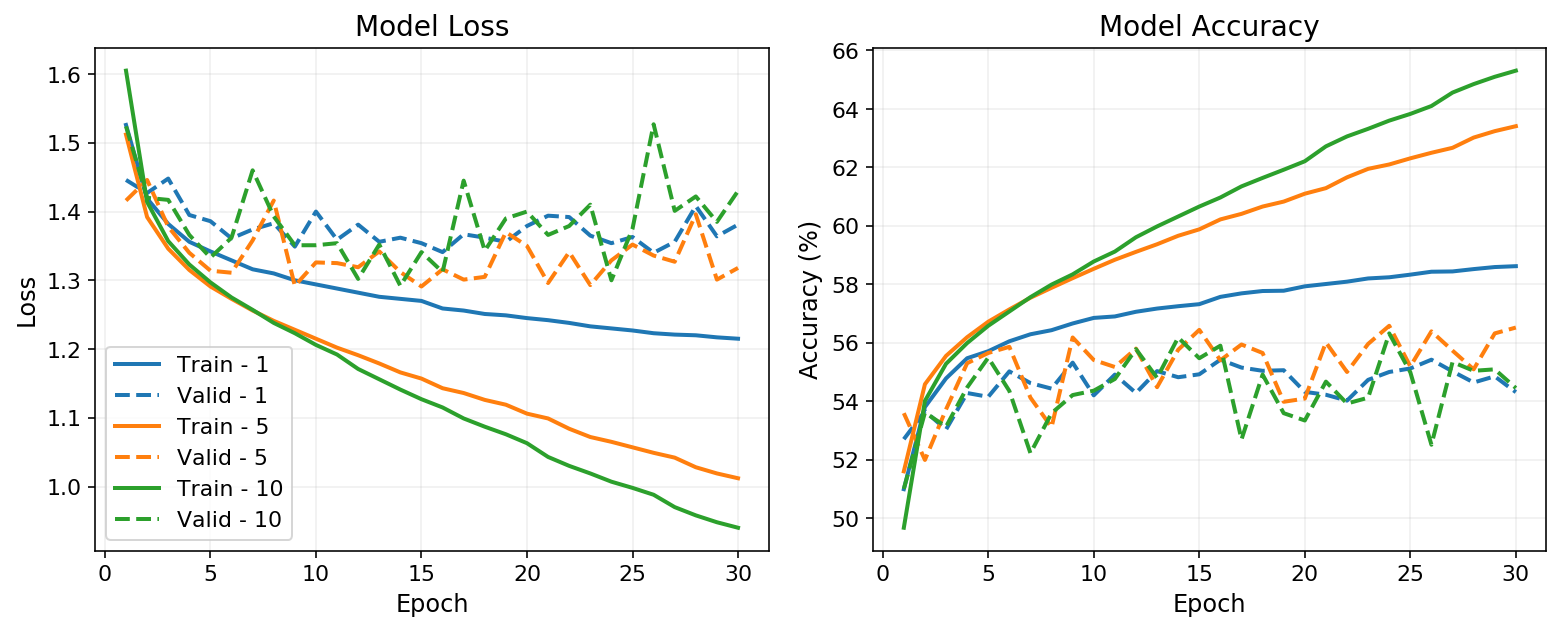

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

plot_loss(df, ax=ax[0])
plot_acc(df, ax=ax[1])

plt.tight_layout()
plt.savefig('training_prog.png', bbox_inches='tight', dpi=300)

In [116]:
## epoch 30 stats

epoch30 = df.query("epoch == 30")[['blocks', 'time', 'train_acc', 'valid_acc', 'train_loss', 'valid_loss']]
epoch30['time'] = np.round(epoch30['time'] / 30, 2)
epoch30.columns = ['Blocks', 'Time (min)', 'Train Acc', 'Valid Acc', 'Train Loss', 'Valid Loss']
epoch30.to_csv('epoch30_stats.csv', index=False)
epoch30

,Blocks,Time (min),Train Acc,Valid Acc,Train Loss,Valid Loss
29,1,4.09,58.62,54.31,1.215,1.381
59,5,15.92,63.41,56.52,1.012,1.318
89,10,31.55,65.31,54.45,0.940,1.430


In [174]:
## contact precision heat

def summarize_contacts():
    
    contacts = list(Path('output').glob('*_contact_precisions.csv'))
    
    df_list = []
    for contact in contacts:
        name = contact.stem.rsplit('_', 3)[0]
        df = pd.read_csv(contact, header=0, names=['metric', 'precision'])
        df['name'] = name
        df_list.append(df)
        
    df = pd.concat(df_list, ignore_index=True)
    df['blocks'] = df['name'].str.split('_', expand=True)[1].astype(int)
    #df['distance'] = df['metric'].str.split('_', expand=True)[0]
    #df['type'] = df['metric'].str.split('_', expand=True)[1]
    
    df_piv = pd.pivot_table(index='blocks', columns='metric', values='precision', data=df)
    ordered = ['short_l', 'short_l/2', 'short_l/5', 'med_l', 'med_l/2', 'med_l/5', 'long_l', 'long_l/2', 'long_l/5']
    
    return df_piv[ordered].reset_index()

In [178]:
contacts = summarize_contacts()
contacts.iloc[:, 1:] = contacts.iloc[:, 1:] * 100
contacts.to_csv('contacts.csv')
contacts

metric,blocks,short_l,short_l/2,short_l/5,med_l,med_l/2,med_l/5,long_l,long_l/2,long_l/5
0,1,59.914971,56.246191,64.055300,66.869116,61.852529,65.745008,69.996963,66.788544,70.046083
1,5,57.515943,54.600853,60.983103,62.739144,59.536868,60.983103,66.443972,67.458867,70.199693
2,10,63.559065,63.193175,72.964670,68.600061,68.312005,75.729647,69.966596,72.821450,77.880184


In [274]:
## heatmap contacts

def heat_contacts(contacts, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    vals = contacts.values[:, 1:]
    p = ax.imshow(vals, aspect='auto', cmap='magma')
    
    y_labs = contacts['blocks'].values
    ax.set_yticks(np.arange(len(contacts)))
    ax.set_yticklabels(y_labs, size=11)
    ax.set_ylabel('Blocks', size=11)
    
    x_labs = [x.title().replace('_', ' ') for x in contacts.columns[1:]]
    ax.set_xticks(np.arange(contacts.shape[1] - 1))
    ax.set_xticklabels(x_labs, rotation=40, rotation_mode='anchor', ha='right', size=11)
    
    plt.colorbar(p, fraction=0.02, label='Precision')
    
    for i in range(len(x_labs)):
        for j in range(len(y_labs)):
            ax.text(i, j, f'{vals[j, i]:.1f}', ha='center', va='center', color='black' if vals[j, i] > 70 else 'white')
    
    ax.set_title('Contact Precision', size=14)
    

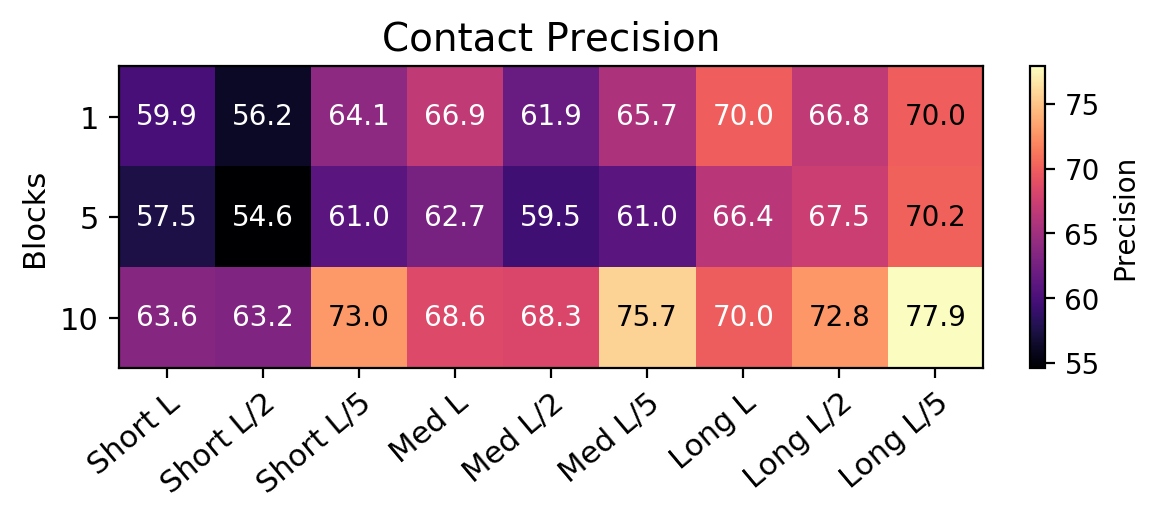

In [278]:
fig = plt.figure(figsize=(6, 2), dpi=100)
heat_contacts(contacts)

plt.savefig('contact_precisions.png', bbox_inches='tight', dpi=300)